# A sinusoidal weight matrix can be learned by Hebbian learning when forcing a sinusoidal input

## Fixing the activity and running the weight updates

In [1]:
import numpy as np
import numpy.lib.stride_tricks
import matplotlib.pyplot as plt
import scipy.linalg
import matplotlib.scale
plt.style.use('seaborn-notebook')
plt.rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
plt.rc('text', usetex=True)
np.random.seed(7) # seed so plots are repeatable
%matplotlib inline
# need the %matplotlib inline for the following to work
plt.rc('figure', figsize = [10,6]) # paper figures should be width 10 (full linewidth) to have nicely readable text

def roll_matrix_rows(matrix, roll_amounts):
	'''roll each row of a 2D matrix by an independent amount, as specified in `roll_amounts`.'''
	matrix_rolled = matrix[:, [*range(matrix.shape[1]),*range(matrix.shape[1]-1)]].copy()
	stride_0, stride_1 = matrix_rolled.strides
	num_cols = matrix.shape[1]
	result = numpy.lib.stride_tricks.as_strided(matrix_rolled, (*matrix.shape, num_cols), (stride_0 ,stride_1, stride_1))
	return result[np.arange(matrix.shape[0]), (num_cols-roll_amounts) % num_cols]

In [2]:
profile_to_matrix = lambda profile: scipy.linalg.circulant(profile)
get_cosine_from_fourier_spectrum = lambda fourier_spectrum: np.fft.ifft(fourier_spectrum).real
circular_concat = lambda x : np.hstack((x, x[0]))

def fill_fourier_modes_up_to_N(last_fourier_mode:int, period: int):
	'''
	Create a vector of length `period` with the elements up to the `last_fourier_mode` filled with ones.
	
	`last_fourier_mode=0` corresponds to just the DC component being filled.
	
	For higher Fourier modes both the positive and negative frequency components are filled.
	
	eg. `fill_fourier_modes_up_to_N(1, 4) = [1,1,0,1]`
	'''
	assert last_fourier_mode <= period//2, f'last fourier mode of {last_fourier_mode} not possible with discrete Fourier vector of length {period}'
	half_fourier_vector = np.zeros(period//2+1)
	half_fourier_vector[:last_fourier_mode+1] = 1
	return np.hstack((half_fourier_vector, np.flip(half_fourier_vector[1:-1])))

def fill_fourier_modes_in_range(first_fourier_mode:int, last_fourier_mode:int, period: int):
	'''
	Create a vector of length `period` with the elements between `first_fourier_mode` and `last_fourier_mode` (inclusive) filled with ones, with other Fourier modes = 0.
	
	eg. `fill_fourier_modes_in_range(1, 2, 4) = [0,1,1,1]`
	'''
	fourier_spectrum = (fill_fourier_modes_up_to_N(last_fourier_mode, period) - fill_fourier_modes_up_to_N(first_fourier_mode-1, period))
	return fourier_spectrum


N = 8
neuron_indices = np.arange(N)
v_magnitude = 0.25
a = v_magnitude * np.cos(2*np.pi*neuron_indices/N) # a = ||v|| * F^-1{[1,0,0,...]}
_lambda = 1/4*N*v_magnitude**2
input = profile_to_matrix(a)

In [3]:
def simulate_and_plot_fixed_activity(a, W0=None, eta=0.01, _lambda=5.0, plot=True, show=True):
	N = a.shape[1]
	if W0 is None:
		W = np.zeros((N,N))
	else:
		W = W0.copy()

	delta_W_trace = []
	W_trace = []

	for t in range(a.shape[0]):
		delta_W = a[t,:].reshape(N,1) @ a[t,:].reshape(1,N) - _lambda*W
		W += eta*delta_W
		delta_W_trace.append(delta_W.copy())
		W_trace.append(W.copy())

	if plot:
		plt.pcolor(W)
		plt.colorbar()
		if show:
			plt.show()
		plt.figure()
		plot_circulant_matrix_as_profile(W, show=show)

	return W, np.array(delta_W_trace), np.array(W_trace)

def get_circulant_matrix_profile(matrix):
	N = np.arange(matrix.shape[0])
	unrolled_matrix = roll_matrix_rows(matrix, -N)

	mu = unrolled_matrix.mean(axis=0)
	stddev = np.sqrt(unrolled_matrix.var(axis=0))

	return mu, stddev

def plot_circulant_matrix_as_profile(matrix, plot_stddev=True, roll=False, show=True):
	N = np.arange(matrix.shape[0]+1)
	mu, stddev = get_circulant_matrix_profile(matrix)
	if roll:
		N -= matrix.shape[0]//2
		mu = np.roll(mu, matrix.shape[0]//2)
		stddev = np.roll(stddev, matrix.shape[0]//2)

	plt.plot(N, circular_concat(mu), 'o--', markersize=6, linewidth=1)
	if plot_stddev:
		plt.fill_between(N, circular_concat(mu-stddev), circular_concat(mu+stddev), alpha=0.2)
	if show:
		plt.show()

## functions for generating phase portrait
def profile_to_mu_amp_phase(profile):
	return profile.mean(), (profile.max()-profile.min())/2, np.argmax(profile)

def grad_over_period(W, a, _lambda):
	grad_W = np.zeros_like(W)
	for t in range(a.shape[0]):
		grad_W += a[t,:].reshape(N,1) @ a[t,:].reshape(1,N) - _lambda*W
	return grad_W

def get_grad_over_period(mu, amp, eta=0.01, _lambda=5.0):
	W = profile_to_matrix(mu + amp*np.cos(2*np.pi*neuron_indices/N))
	mu_before, amp_before, phase_before = profile_to_mu_amp_phase(get_circulant_matrix_profile(W)[0])
	mu_after, amp_after, phase_after = profile_to_mu_amp_phase(get_circulant_matrix_profile(W+eta*grad_over_period(W, input, _lambda))[0])
	return (mu_after-mu_before, amp_after-amp_before, phase_after-phase_before)

The weights converge to a sinusoidal profile which corresponds to the weights which make any sinusoidal activity stable

### Checking the effect of the learning rate, $\eta$

Increasing the learning rate speeds up the convergence of the weights, but also increases the final weight variance (because the weights move around more during a period, even once they have converged).

The convergence time depends inversely on the learning rate.

The final standard deviation scales linearly with the learning rate, up until some point where it seems to saturate.

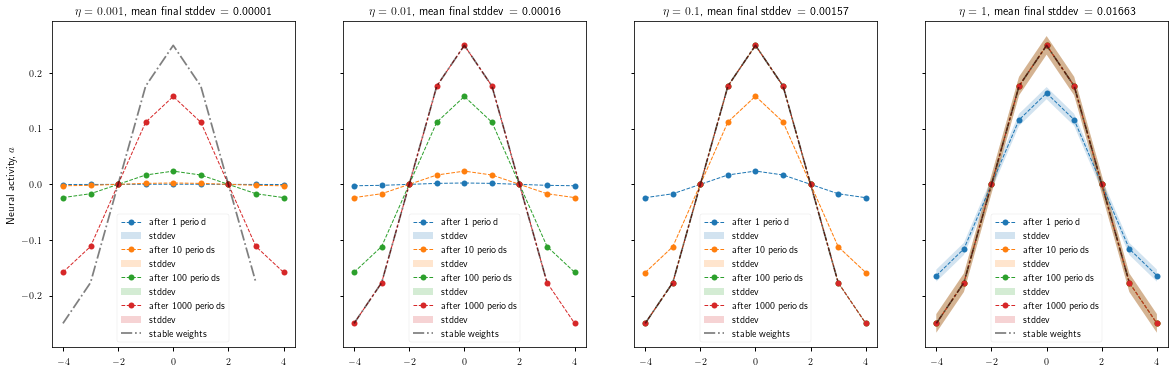

In [4]:
fig, axs=plt.subplots(1,4, sharey=True, figsize=(20,6))

for eta, ax in zip([0.001, 0.01, 0.1, 1], axs):
	W, delta_W_trace, W_trace = simulate_and_plot_fixed_activity(np.tile(input, (1000,1)), plot=False, _lambda=_lambda, eta=eta)

	plt.sca(ax)
	plot_circulant_matrix_as_profile(W_trace[N*1-1,:,:], plot_stddev=True, roll=True, show=False)
	plot_circulant_matrix_as_profile(W_trace[N*10-1,:,:], plot_stddev=True, roll=True, show=False)
	plot_circulant_matrix_as_profile(W_trace[N*100-1,:,:], plot_stddev=True, roll=True, show=False)
	plot_circulant_matrix_as_profile(W_trace[N*1000-1,:,:], plot_stddev=True, roll=True, show=False)
	plt.plot(neuron_indices-N//2, np.roll(get_cosine_from_fourier_spectrum(fill_fourier_modes_in_range(1, 1, N)), N//2), 'k-.', alpha=0.5)
	plt.legend(['after 1 period','stddev','after 10 periods','stddev','after 100 periods','stddev','after 1000 periods','stddev','stable weights'])
	plt.title(f'$\\eta = {eta}$, mean final stddev = {get_circulant_matrix_profile(W_trace[N*1000-1,:,:])[1].mean():.5f}')
axs[0].set_ylabel('Neural activity, $a$')
plt.show()

### Building a phase portrait of the system

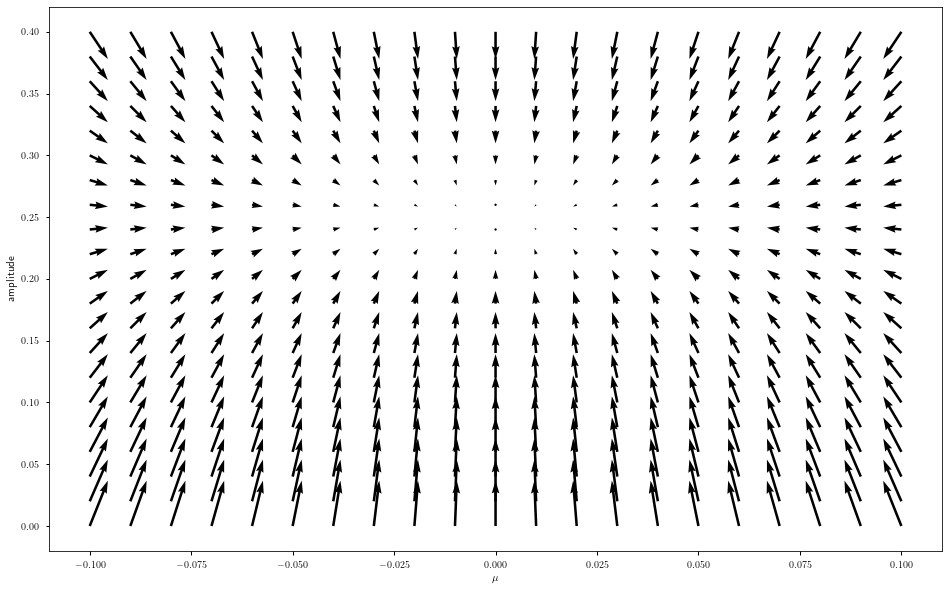

In [5]:
mu_range = np.arange(-0.1,0.105,.01)
amp_range = np.arange(0.0,0.41,.02)
mu_grid, amp_grid = np.meshgrid(mu_range, amp_range)

mu_grad = np.zeros((len(mu_range), len(amp_range)))
amp_grad = np.zeros((len(mu_range), len(amp_range)))
phase_grad = np.zeros((len(mu_range), len(amp_range)))

for i,mu in enumerate(mu_range):
	for j,amp in enumerate(amp_range):
		grad_mu, grad_amp, grad_phase = get_grad_over_period(mu, amp, _lambda=_lambda)
		mu_grad[i,j] = grad_mu
		amp_grad[i,j] = grad_amp
		phase_grad[i,j] = grad_phase

plt.figure(figsize=(16,10))
plt.quiver(mu_grid, amp_grid, mu_grad.T, amp_grad.T)
plt.xlabel('$\\mu$')
plt.ylabel('amplitude')
plt.show()

### Plotting the results

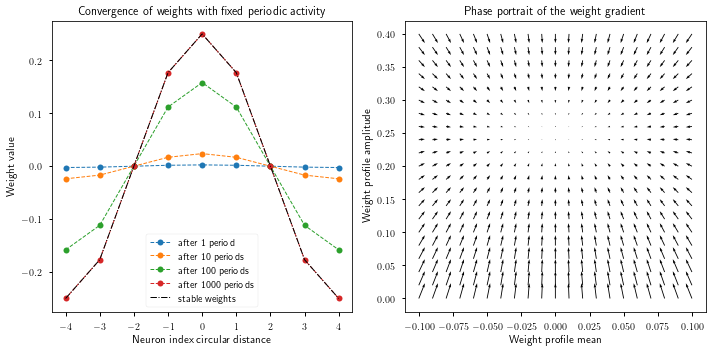

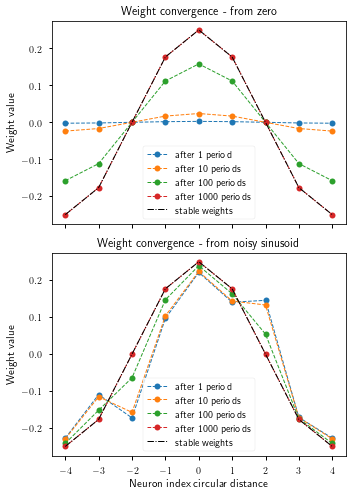

In [6]:
eta=0.01
W0 = profile_to_matrix(get_cosine_from_fourier_spectrum(fill_fourier_modes_in_range(1, 1, N))) + 0.2*np.random.randn(N,N)
W, delta_W_trace, W_trace = simulate_and_plot_fixed_activity(np.tile(input, (1000,1)), plot=False, _lambda=_lambda, eta=eta)
W_noise, delta_W_trace_noise, W_trace_noise = simulate_and_plot_fixed_activity(np.tile(input, (1000,1)), W0=W0, plot=False, _lambda=_lambda, eta=eta)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
plt.sca(axs[0])
plot_circulant_matrix_as_profile(W_trace[N*1-1,:,:], plot_stddev=False, roll=True, show=False)
plot_circulant_matrix_as_profile(W_trace[N*10-1,:,:], plot_stddev=False, roll=True, show=False)
plot_circulant_matrix_as_profile(W_trace[N*100-1,:,:], plot_stddev=False, roll=True, show=False)
plot_circulant_matrix_as_profile(W_trace[N*1000-1,:,:], plot_stddev=False, roll=True, show=False)
axs[0].plot(np.arange(-N//2, N//2+1), circular_concat(np.roll(get_cosine_from_fourier_spectrum(fill_fourier_modes_in_range(1, 1, N)), N//2)), 'k-.', linewidth=1)
axs[0].legend(['after 1 period','after 10 periods','after 100 periods','after 1000 periods','stable weights'])
# handles, labels = axs[0].get_legend_handles_labels()
# axs[0].legend(handles[::-1], labels[::-1])
plt.title(f'Convergence of weights with fixed periodic activity')
plt.ylabel('Weight value')
plt.xlabel('Neuron index circular distance')

plt.sca(axs[1])
plt.quiver(mu_grid, amp_grid, mu_grad.T, amp_grad.T)
plt.xlabel('Weight profile mean')
plt.ylabel('Weight profile amplitude')
plt.title('Phase portrait of the weight gradient')
plt.tight_layout()
plt.savefig('plots/hebbian-learning-fixed-activity-negative-activity.pdf')
plt.show()

# Just the left figure, also with weight perturbation noise rejection
fig, axs = plt.subplots(2, 1, figsize=(5,7), sharex=True)
plt.sca(axs[0])
plot_circulant_matrix_as_profile(W_trace[N*1-1,:,:], plot_stddev=False, roll=True, show=False)
plot_circulant_matrix_as_profile(W_trace[N*10-1,:,:], plot_stddev=False, roll=True, show=False)
plot_circulant_matrix_as_profile(W_trace[N*100-1,:,:], plot_stddev=False, roll=True, show=False)
plot_circulant_matrix_as_profile(W_trace[N*1000-1,:,:], plot_stddev=False, roll=True, show=False)
plt.plot(np.arange(-N//2, N//2+1), circular_concat(np.roll(get_cosine_from_fourier_spectrum(fill_fourier_modes_in_range(1, 1, N)), N//2)), 'k-.', linewidth=1)
plt.legend(['after 1 period','after 10 periods','after 100 periods','after 1000 periods','stable weights'])
# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles[::-1], labels[::-1])
plt.title(f'Weight convergence - from zero')
plt.ylabel('Weight value')
# plt.xlabel('Neuron index circular distance')

plt.sca(axs[1])
plot_circulant_matrix_as_profile(W_trace_noise[N*1-1,:,:], plot_stddev=False, roll=True, show=False)
plot_circulant_matrix_as_profile(W_trace_noise[N*10-1,:,:], plot_stddev=False, roll=True, show=False)
plot_circulant_matrix_as_profile(W_trace_noise[N*100-1,:,:], plot_stddev=False, roll=True, show=False)
plot_circulant_matrix_as_profile(W_trace_noise[N*1000-1,:,:], plot_stddev=False, roll=True, show=False)
plt.plot(np.arange(-N//2, N//2+1), circular_concat(np.roll(get_cosine_from_fourier_spectrum(fill_fourier_modes_in_range(1, 1, N)), N//2)), 'k-.', linewidth=1)
plt.legend(['after 1 period','after 10 periods','after 100 periods','after 1000 periods','stable weights'])
# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles[::-1], labels[::-1])
plt.title(f'Weight convergence - from noisy sinusoid')
plt.ylabel('Weight value')
plt.xlabel('Neuron index circular distance')

plt.tight_layout()
plt.savefig('plots/hebbian-learning-fixed-activity-negative-activity-weight-convergence.pdf')
plt.show()